In [170]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy

%matplotlib inline
# %matplotlib

In [2]:
# https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(float(x), float(y), float(z), float(dx), float(dy), float(dz), mutation_scale=5, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [66]:
from matplotlib.axes import Axes
def _fancy_arrow(ax, x, y, dx, dy, *args, **kwargs):
    arrow = FancyArrowPatch((x, y), (x + dx, y + dy), mutation_scale=7, *args, **kwargs)
    ax.add_patch(arrow)
    
setattr(Axes, 'fancy_arrow', _fancy_arrow)

In [242]:
def grad(f, *vs):
    return [f.diff(x).expand() for x in vs]
def hessian(f, *vs):
    return [[f.diff(x).diff(y).expand() for y in vs] for x in vs]

In [243]:
def expr_to_C(s):
    r = str(s)
    for i in range(10):
        for v in ['x', 'y'] + ['x' + str(i) for i in range(1, 10)]:
            r = r.replace(v + '**' + str(i), '*'.join([v]*i))
    for i in range(1, 10):
        r = r.replace('x' + str(i), 'args[' + str(i - 1) + ']')
    return r
def list_to_C(l, f):
    return '{' + ', '.join(map(f, l)) + '}'
def list2_to_C(l, f):
    return '{' + ', '.join(map(lambda e: list_to_C(e, f), l)) + '}'

In [244]:
class Function:
    
    def plot3(self, left, right, n, steps = []):
        X, Y, Z = self._calc_func(left, right, n)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot_wireframe(X, Y, Z)
    
        for ((x, y), (dx, dy)) in self._get_arrows(steps):
            z = self.__call__(x, y)
            dz = self.__call__(x + dx, y + dy) - z
            ax.arrow3D(x, y, z, dx, dy, dz, color='red')
            
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')
        return fig
    
    def plot_contours(self, left, right, n, levels, steps = []):
        X, Y, Z = self._calc_func(left, right, n)
        fig = plt.figure()
        ax = plt.subplot()
#         cntrs = ax.contour(X, Y, Z, levels = levels)
        cntrs = ax.contour(X, Y, Z)
        fmt = {}
        for c in cntrs.levels:
            fmt[c] = '%.02f' % c
        ax.clabel(cntrs, cntrs.levels[::1], fmt=fmt)

        for ((x, y), (dx, dy)) in self._get_arrows(steps):
            ax.fancy_arrow(x, y, dx, dy, color='red')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        return fig
    
    def _calc_func(self, left, right, n):
        assert self.arity() == 2, "Only functions with 2 arguments supported"
        X = np.linspace(left, right, n)
        Y = np.linspace(left, right, n)
        X, Y = np.meshgrid(X, Y)
        Z = []
        for i in range(len(X)):
            z = []
            for j in range(len(Y)):
                z.append(self.__call__(X[i][j], Y[i][j]))
            Z.append(np.array(z, dtype='float64'))
        Z = np.array(Z, dtype='float64')
        return (X, Y, Z)
    
    def _get_arrows(self, steps = []):
        if len(steps) == 0:
            return
        prev = steps[0]
        for p in steps[1:]:
            if p[0] - prev[0] != 0 or p[1] - prev[1] != 0:
                yield ((prev[0], prev[1]), (p[0] - prev[0], p[1] - prev[1]))
            prev = p
        
class QuadFunction(Function):
    
    def __init__(self, A, b, c):
            self.A = np.array(list(map(np.array, A)))
            self.b = np.array(b)
            self.c = c
            
    def __call__(self, *x):
        x = np.array(x)
        return 1/2 * self.A.dot(x).dot(x) + self.b.dot(x) + self.c
    
    def grad(self, *x):
        return self.A.dot(x) + self.b
    def hessian(self, *x):
        return self.A

    def arity(self):
        return len(self.b)
    
    def __str__(self):
        def to_C_list(l, f):
            return '{' + ', '.join(map(f, l)) + '}'
        return 'new_quad_func(' + ', '.join([list2_to_C(self.A, str), list_to_C(self.b, str), str(self.c)]) + ')'
    
class RegularFunction(Function):
    
    def __init__(self, expr, *args):
        self.expr = expr.expand()
        self.vars = args
    
    def _eval(self, expr, *x):
        res = expr
        for (a, v) in zip(self.vars, x):
            res = res.subs(a, v)
        return res
    
    def __call__(self, *x):
        return self._eval(self.expr, *x)
    
    def grad(self, *x):
        return np.array(list(map(lambda e: self._eval(e, *x), grad(self.expr, *self.vars))))
    
    def hessian(self, *x):
        H = hessian(self.expr, *self.vars)
        return np.array(list(map(lambda l: np.array(list(map(lambda e: self._eval(e, *x), l))), H)))
        # return H
        
    def arity(self):
        return len(self.vars)
    
    
    def __str__(self):
        return '''
        new ordinary_function(
            [](Vector<double> args) -> double { 
                double x = args[0];
                double y = args[1];
                return %s; 
            },
            [](Vector<double> args) -> std::vector<double> {
                double x = args[0];
                double y = args[1];
                return %s;
            },
            [](Vector<double> args) -> std::vector<std::vector<double>> {
                double x = args[0];
                double y = args[1];
                return %s;
            })''' % (expr_to_C(self.__call__(*self.vars)), 
                      list_to_C(self.grad(*self.vars), expr_to_C), 
                      list2_to_C(self.hessian(*self.vars), expr_to_C))

In [245]:
def functions_to_C(*fs):
    res = ''
    n = 1
    for f in fs:
        f.n = n
        n += 1
        res += 'functions.push_back(%s);\n' % str(f)
    return res
def save_functions(*fs):
    code = functions_to_C(*fs)
    with open(str(Runner.build_dir / '../lab4cli/src/functions.inl'), 'w') as f:
        f.write(code)
    Runner.recompile()

In [246]:
import enum
import subprocess
import os
import math
from pathlib import Path

class Method(enum.Enum):
    MARQUARDT = 'marquardt'
    MARQUARDT_CHOLESKY = 'marquardt_cholesky'
    POWELL = 'powell'
    BFS = 'bfs'
    NEWTON_ORDINARY =  'newton_ordinary'
    NEWTON_WITH_SEARCH = 'newton_with_search'
    NEWTON_WITH_DESCENT = 'newton_with_descent'


class Runner:
    
    build_dir = Path('../../build')
    
    def __init__(self):
        pass
    
    def run(self, method, init, f, eps = 1e-4):
        cli = self.build_dir / 'lab4cli/lab4cli'
        proc = subprocess.Popen([str(cli), 
                                 '-m', method.value, 
                                 '-i', ' '.join(map(str, init)), 
                                 '-e', str(eps),
                                 '-f', str(f)], stdout=subprocess.PIPE)
        out = proc.communicate()[0].decode()
#         print(out)
        return self._parse_output(out.split(), init)
        
    def _parse_output(self, out, init):
        def nxt():
            return out.pop(0)
        def nxt_int():
            return int(nxt())
        def nxt_float():
            return float(nxt())
        def test(ch):
            if len(out) == 0:
                return False
            if out[0] == ch:
                nxt()
                return True
            else:
                return False
        def read_extra():
            extra = []
            if test('['):
                while not test(']'):
                    extra.append(nxt_float())
            return extra
        def nxt_flist(n):
            res = []
            for i in range(n):
                res.append(nxt_float())
            return res
        n = len(init)
        f_min = nxt_float()
        x_min = nxt_flist(n)
        
        iters = nxt_int()
        iters_data = []
        for i in range(iters):
            iters_data.append((nxt_flist(n), read_extra()))
        return (x_min, iters_data)
    
    @staticmethod
    def recompile():
        print("Recompiling...")
        r = os.system(' '.join(['make', '-C', str(Runner.build_dir)]))
        if r != 0:
            print("Failed to reccompile")
        else:
            print("Recompiled succesfuly")
def get_steps(data):
    res = []
    x_min = data[0][0][0]
    x_max = data[0][0][0]
    y_min = data[0][0][1]
    y_max = data[0][0][1]
    for (d, _) in data:
        x_min = min(x_min, d[0])
        x_max = max(x_max, d[0])
        x_min = min(x_min, d[1])
        x_max = max(x_max, d[1])
        res.append(d)
    x_range = max(x_max - x_min, 1)
    x_min = x_min - x_range/3
    x_max = x_max + x_range/3
    y_range = max(y_max - y_min, 1)
    y_min = y_min - y_range/3
    y_max = y_max + y_range/3
    return (res, min(x_min, y_min), max(x_max, y_max))

def get_extra(data, i = None):
    res = []
    for (_, e) in data:
        if i == None:
            res.append(e)
        else:
            res.append(e[i])
    return res

def get_levels(f, steps):
    l = list(set(map(lambda a: f(*a), steps)))
    l.sort()
    return l

In [276]:
def plot_all_methods_abstr(f, init, plt_impl, pref = 'none', methods = Method):
    runner = Runner()
    iters = []
    ress = []
    for method in methods:
        (x_min, data) = runner.run(method, init, f.n)
        (steps, left, right) = get_steps(data)
        fig = plt_impl(f, left, right, 20, steps)
        fig.suptitle(method.value)
        plt.savefig(str(Runner.build_dir / ('../scripts/lab4/plots/' + pref + '_' + method.value + '_' + str(f.n))), dpi=300)
        
        iters.append(len(data))
        ress.append((x_min, f(*x_min)))
    
    print(iters)
    print(ress)
def run_all_methods(f, init, methods = Method):
    runner = Runner()
    iters = []
    ress = []
    for method in methods:
        (x_min, data) = runner.run(method, init, f.n)
        iters.append(len(data))
        ress.append((x_min, f(*x_min)))
    
    print(iters)
    print(ress)
        
def plot_all_contours(f, init, methods = Method):
    def impl(f, left, right, dens, steps):
        return f.plot_contours(left, right, dens, get_levels(f, steps), steps)
    return plot_all_methods_abstr(f, init, impl, pref='contours', methods = methods)

def plot_all_3D(f, init, methods = Method):
    def impl(f, left, right, dens, steps, methods = Method):
        return f.plot3(left, right, dens, steps)
    return plot_all_methods_abstr(f, init, impl, pref='3D', methods = methods)

In [248]:
def get_extra(f, method, init):
    runner = Runner()
    (x_min, data) = runner.run(method, init, f.n)
    extra = []
    for (_, e) in data:
        extra.append(e)
    return extra

# Function 1
$f(\vec{x}) = \frac{1}{2} \left\langle \begin{pmatrix} 2 & -1 \\ -1 & 1 \end{pmatrix} x, x \right\rangle + \langle \begin{pmatrix} 2 & -3 \end{pmatrix} , x \rangle + 10$

$x_0 = \begin{pmatrix} 1 & 1 \end{pmatrix}$

# Function 2
$f(x, y) = 2 \cdot x^2 + 3 \cdot y^2 + x^2 \cdot y$

# Function 3
$f(x, y) = e^{\frac{x^2 \cdot y}{10}}$

In [256]:
f1 = QuadFunction([[2, -1], [-1, 1]], [2, -3], 10)

x, y = sy.Symbol('x'), sy.Symbol('y')
f2 = RegularFunction(2 * x * x + 3 * y * y + x**2 * y, x, y)

f3 = RegularFunction(sy.exp(x**2), x, y)

# Functions from 1.2
f4 = RegularFunction(x**2 + y**2 - 1.2 * x * y, x, y)
f5 = RegularFunction(100 * (y - x**2)**2 + (1 - x**2)**2, x, y)


# Functions from 2
x = [sy.Symbol('x' + str(i)) for i in range(0, 5)]
f21 = RegularFunction(100 * (x[1] - x[1]**2)**2 + (1 - x[1])**2, *x[1:3])
f22 = RegularFunction((x[1]**2 + x[2] - 11)**2 + (x[1] + x[2]**2 - 7)**2, *x[1:3])
f23 = RegularFunction((x[1] + 10*x[2])**2 + 5 * (x[3] - x[4])**2 + (x[2] - 2 * x[3])**4 + 10 * (x[1] - x[4])**4, *x[1:5])
f24 = RegularFunction(100 - 2 / (1 + (x[1] - 1)**2/4 + (x[2] - 1)**2/9) - 1 / (1 + (x[1] - 2)**2/4 + (x[2] - 1)**2/9), *x[1:3])

save_functions(f1,f2, f3, f4, f5, f21, f22, f23, f24)

Recompiling...
Recompiled succesfuly


In [195]:
get_extra(f1, Method.NEWTON_WITH_DESCENT, [1, 1])

[[], [0.4], [1.0], [-9.99886]]

[10, 3, 4, 4, 3, 3, 4]
[([1.0, 4.0], 5.0), ([1.0, 4.0], 5.0), ([1.0, 4.0], 5.0), ([1.0, 4.0], 5.0), ([1.0, 4.0], 5.0), ([1.0, 4.0], 5.0), ([1.0, 4.0], 5.0)]


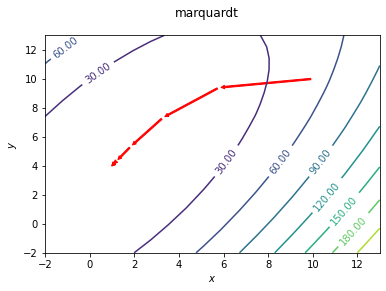

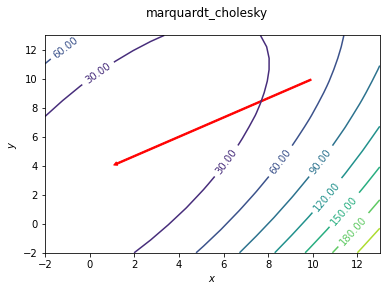

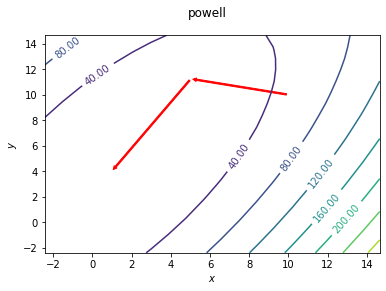

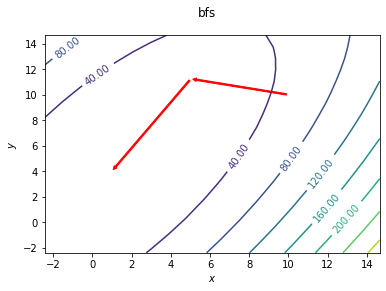

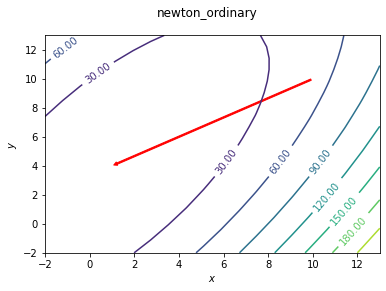

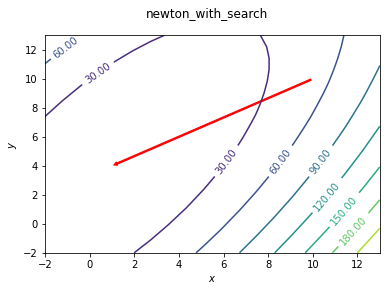

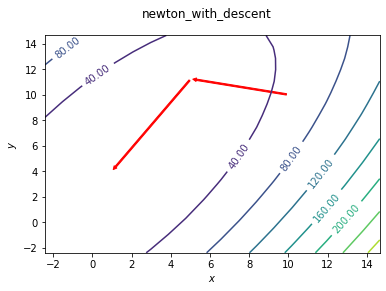

In [219]:
plot_all_contours(f1, [10, 10])
# plot_all_3D(f1, [1, 1])

[76, 8, 33, 16, 8, 48, 5]
[([-1.93339e+38, -1.36711e+38], -5.11025293115883e+114), ([-3.4641, -2.0], 12.0000000000000), ([-5.90531e+31, -2.6466e+38], -9.22940512865983e+101), ([-1.21575e+34, -4.54351e+36], -6.71552615244938e+104), ([-3.4641, -2.0], 12.0000000000000), ([-4.15763e+37, -8.63063e+37], -1.49188096790794e+113), ([-1.81478e+36, -4.59946e+36], -1.51479832123579e+109)]
[7, 5, 34, 17, 5, 50, 5]
[([1.62444e-08, 1.99028e-09], 5.39644706680396e-16), ([2.27734e-10, 5.00813e-10], 8.56166532444974e-19), ([-7.40565e+30, -2.25217e+38], -1.23517227550297e+100), ([5.07795e+29, -2.43553e+32], -6.28015444084748e+91), ([2.27734e-10, 5.00813e-10], 8.56166532444974e-19), ([-3.74646e+37, -3.38155e+38], -4.74633090987320e+113), ([-6.08908e+22, -2.36563e+22], -8.77102157017412e+67)]


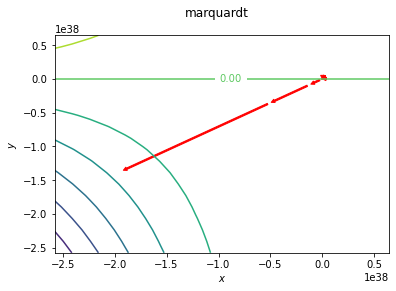

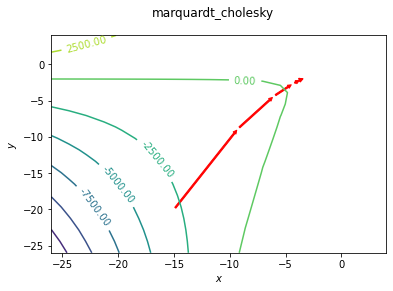

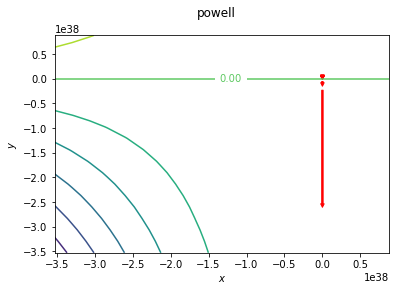

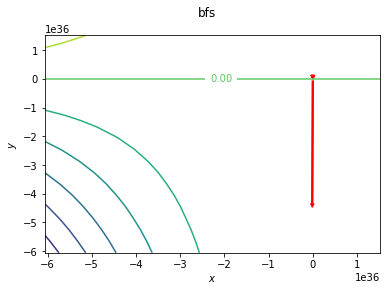

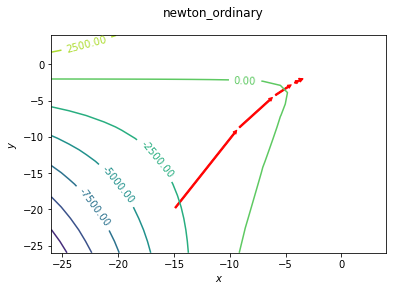

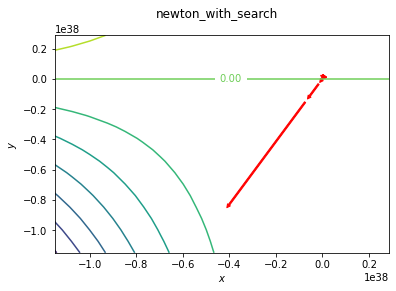

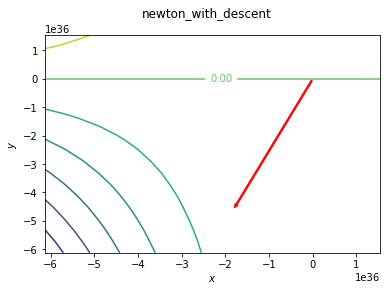

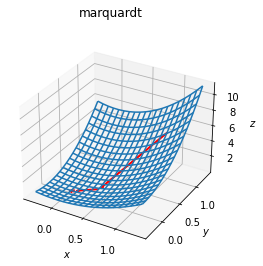

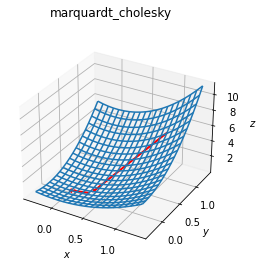

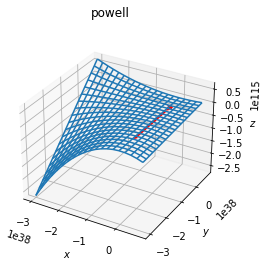

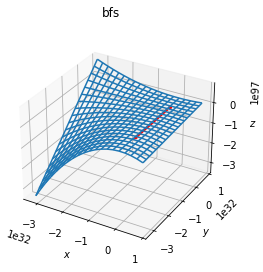

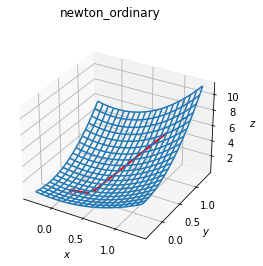

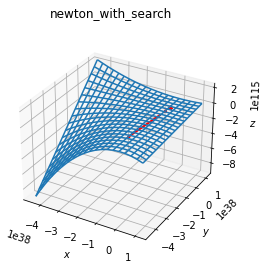

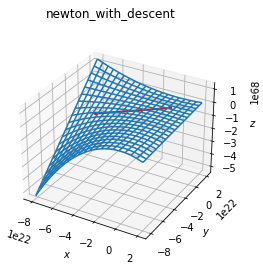

In [223]:
plot_all_contours(f2, [-15, -20])
plot_all_3D(f2, [1, 1])

<ipython-input-138-cfa67f968b02>:24: UserWarning: No contour levels were found within the data range.
  cntrs = ax.contour(X, Y, Z)


[8, 1, 3, 3, 1, 1, 2]
[([2.605e-08, 1.0], 1.00000000000000), ([1.0, 1.0], 2.71828182845905), ([7.46873e-09, 1.0], 1.00000000000000), ([7.46873e-09, 1.0], 1.00000000000000), ([1.0, 1.0], 2.71828182845905), ([1.0, 1.0], 2.71828182845905), ([4.38123e-06, 1.0], 1.00000000001920)]
[8, 1, 3, 3, 1, 1, 2]
[([2.605e-08, 1.0], 1.00000000000000), ([1.0, 1.0], 2.71828182845905), ([7.46873e-09, 1.0], 1.00000000000000), ([7.46873e-09, 1.0], 1.00000000000000), ([1.0, 1.0], 2.71828182845905), ([1.0, 1.0], 2.71828182845905), ([4.38123e-06, 1.0], 1.00000000001920)]


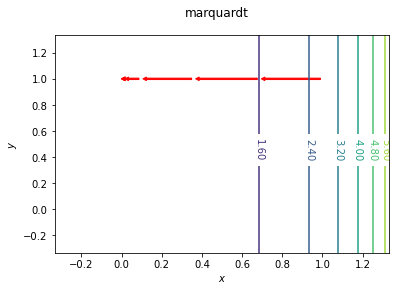

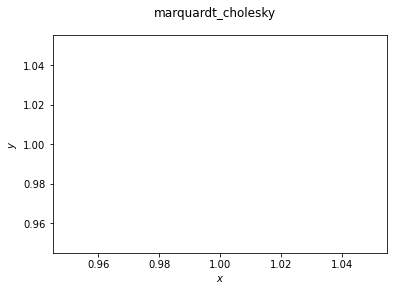

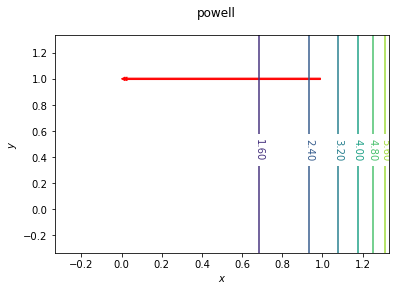

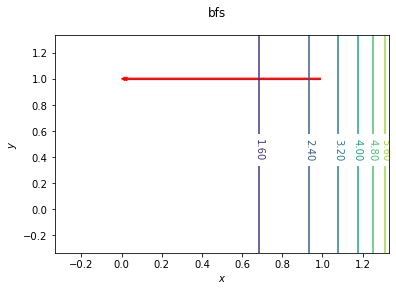

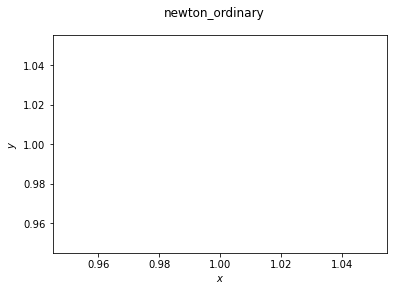

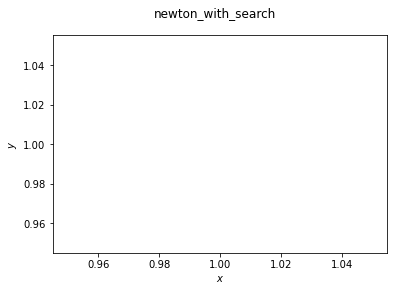

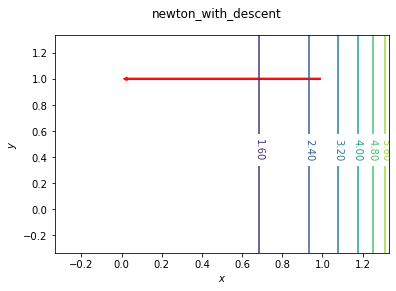

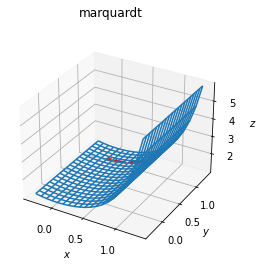

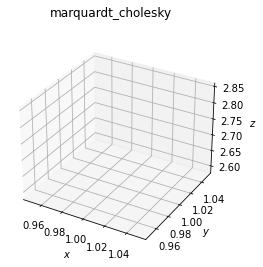

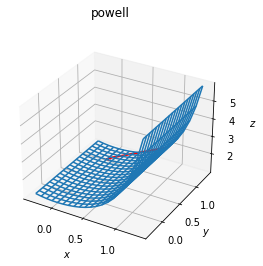

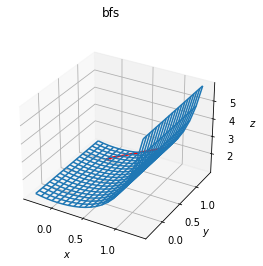

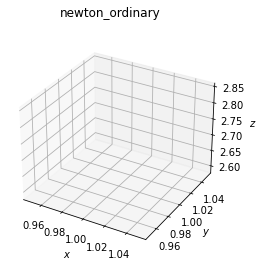

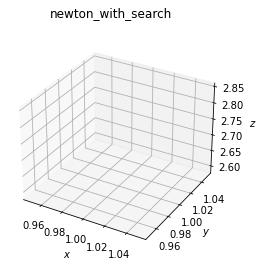

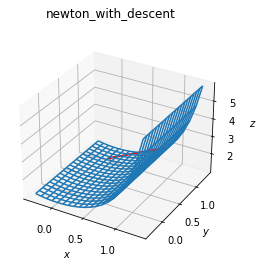

In [146]:
init = [1, 1]
plot_all_contours(f3, init)
plot_all_3D(f3, init)

[8, 3, 4, 4, 3, 3, 4]
[([8.97097e-07, 8.9686e-07], 6.43656388505000e-13), ([0.0, 0.0], 0), ([1.97215e-31, 1.97215e-31], 3.11150049800000e-62), ([3.9443e-31, -1.97215e-31], 2.87813796065000e-61), ([0.0, 0.0], 0), ([3.9443e-31, -1.47911e-31], 2.47461331697000e-61), ([0.0, -4.93038e-32], 2.43086469444000e-63)]
[8, 3, 4, 4, 3, 3, 4]
[([8.97097e-07, 8.9686e-07], 6.43656388505000e-13), ([0.0, 0.0], 0), ([1.97215e-31, 1.97215e-31], 3.11150049800000e-62), ([3.9443e-31, -1.97215e-31], 2.87813796065000e-61), ([0.0, 0.0], 0), ([3.9443e-31, -1.47911e-31], 2.47461331697000e-61), ([0.0, -4.93038e-32], 2.43086469444000e-63)]


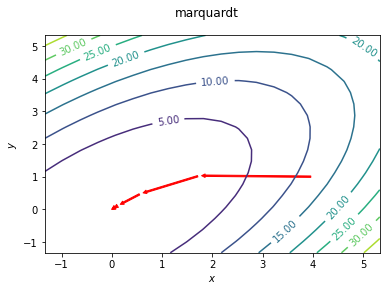

ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

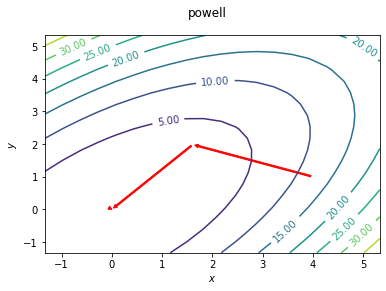

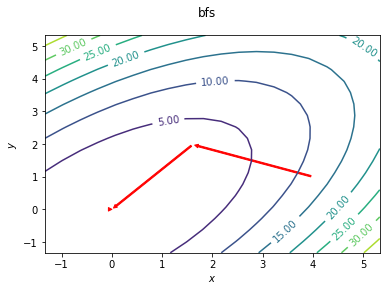

ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

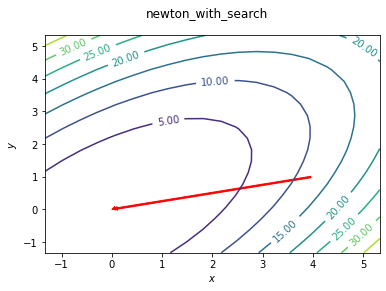

ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

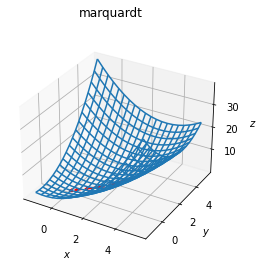

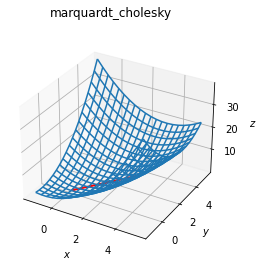

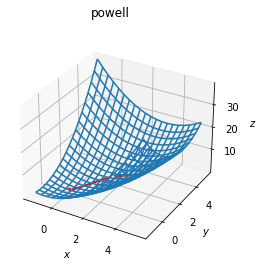

ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

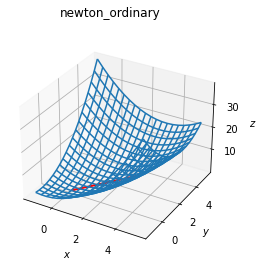

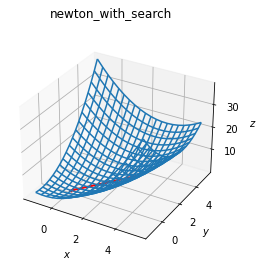

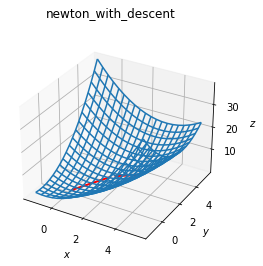

In [221]:
init = [4, 1]
plot_all_contours(f4, init)
plot_all_3D(f4, init)

[8, 7, 7, 7, 7, 7, 6]
[([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0)]
[8, 7, 7, 7, 7, 7, 6]
[([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0), ([-1.0, 1.0], 0)]


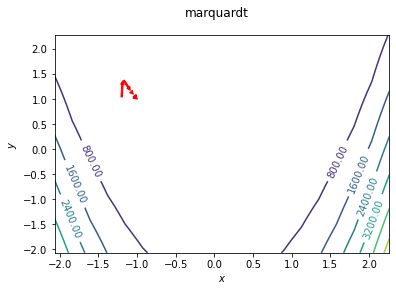

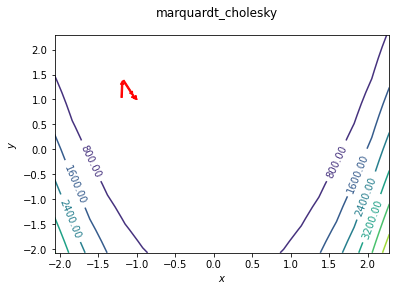

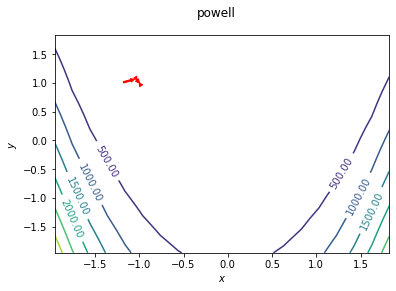

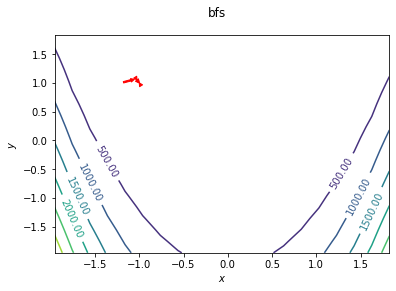

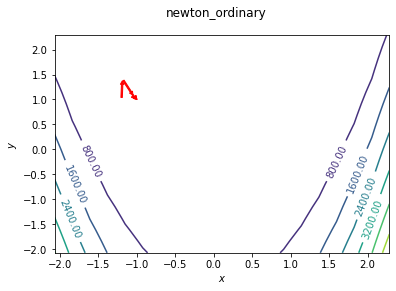

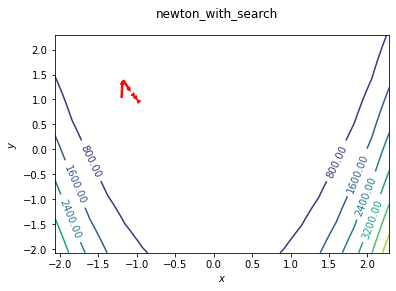

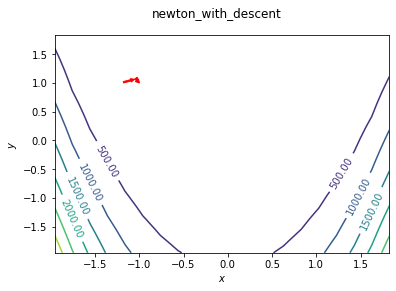

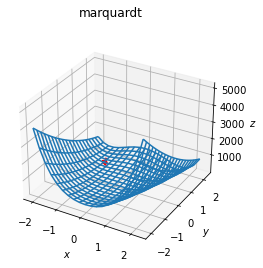

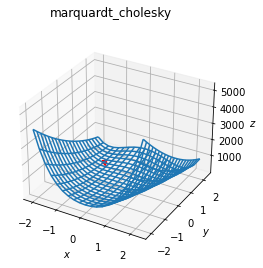

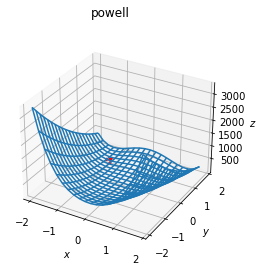

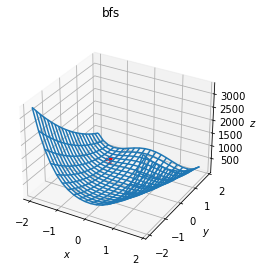

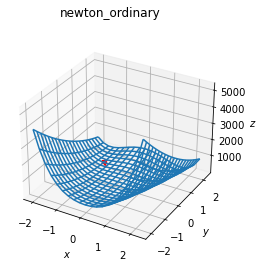

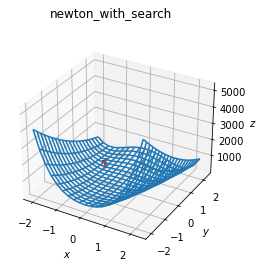

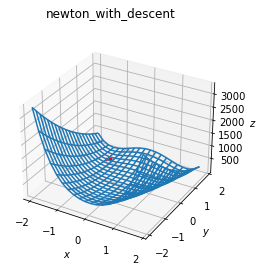

In [222]:
init = [-1.2, 1]
plot_all_contours(f5, init)
plot_all_3D(f5, init)

[3, 3, 2]
[([1.00007, 0.0], 4.94968645625704e-7), ([1.00007, 0.0], 4.94968645625704e-7), ([1.00008, 0.0], 6.46502400059035e-7)]


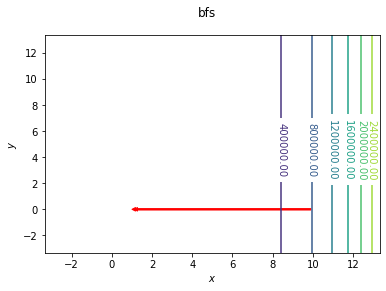

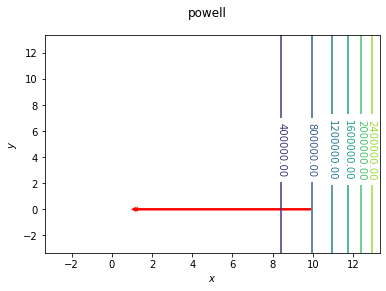

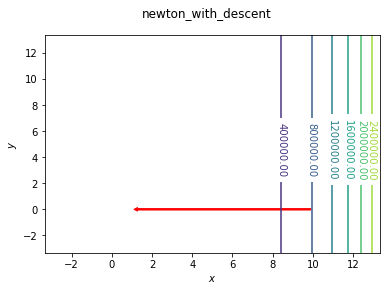

In [273]:
init = [10, 0]
plot_all_contours(f21, init, methods=[Method.BFS, Method.POWELL, Method.NEWTON_WITH_DESCENT])
# plot_all_3D(f21, init, methods=[Method.BFS, Method.POWELL])

[7, 7]
[([-3.77931, -3.28319], 7.41408712201519e-10), ([-3.77931, -3.28319], 7.41408712201519e-10)]
[7, 7]
[([-3.77931, -3.28319], 7.41408712201519e-10), ([-3.77931, -3.28319], 7.41408712201519e-10)]


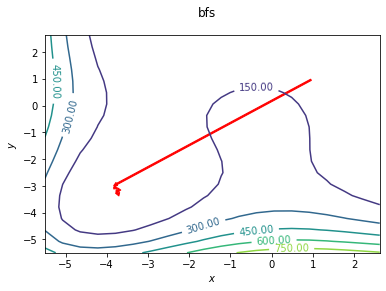

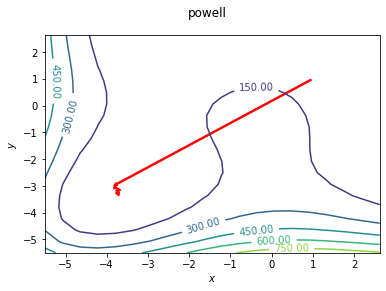

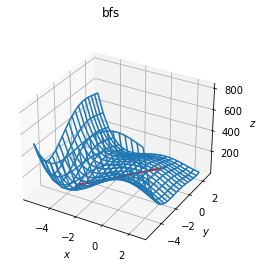

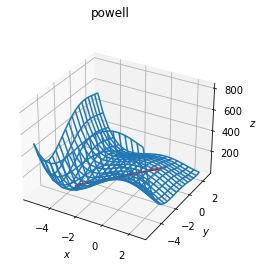

In [290]:
init = [1, 1]
plot_all_contours(f22, init, methods=[Method.BFS, Method.POWELL])
plot_all_3D(f22, init, methods=[Method.BFS, Method.POWELL])

In [279]:
init = [1, 1, 1, 1]
run_all_methods(f23, init, methods=[Method.BFS, Method.POWELL, Method.NEWTON_WITH_DESCENT])
# plot_all_3D(f22, init, methods=[Method.BFS, Method.POWELL])

[16, 15, 18]
[([-0.00856799, 0.000856305, -0.00318865, -0.0031887], 1.11356873628865e-8), ([-0.00859459, 0.000859433, -0.00322575, -0.00322575], 1.11654275595281e-8), ([6.68682e-05, -6.68533e-06, 7.50035e-05, 7.50039e-05], 8.25678393003627e-16)]


[3, 3, 1001]
[([1.15424, 1.0], 97.1635241217471), ([1.15424, 1.0], 97.1635241217471), ([1.15424, 1.0], 97.1635241217471)]


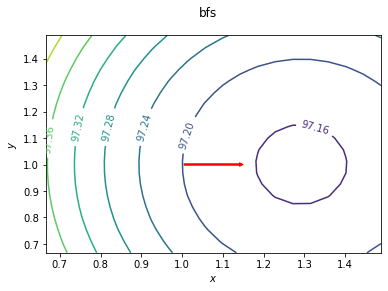

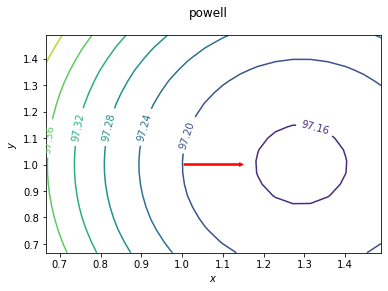

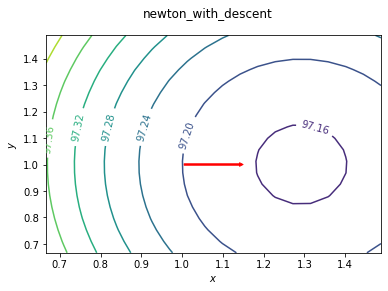

In [275]:
init = [1, 1]
plot_all_contours(f24, init, methods=[Method.BFS, Method.POWELL, Method.NEWTON_WITH_DESCENT])
# plot_all_3D(f24, init, methods=[Method.BFS, Method.POWELL, Method.NEWTON_WITH_DESCENT])